# ADS 509 Sentiment Assignment

This notebook holds the Sentiment Assignment for Module 6 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In a previous assignment you put together Twitter data and lyrics data on two artists. In this assignment we apply sentiment analysis to those data sets. If, for some reason, you did not complete that previous assignment, data to use for this assignment can be found in the assignment materials section of Blackboard. 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [209]:
import os
import re
import emoji
import pandas as pd
import numpy as np
import string
import seaborn as sns
import matplotlib as plt
from collections import Counter, defaultdict
from string import punctuation

from nltk.corpus import stopwords

sw = stopwords.words("english")

In [210]:
# Add any additional import statements you need here

from glob import glob

In [211]:
# change `data_location` to the location of the folder on your machine.
data_location = "."

# These subfolders should still work if you correctly stored the 
# data from the Module 1 assignment
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

positive_words_file = "positive-words.txt"
negative_words_file = "negative-words.txt"
tidy_text_file = "tidytext_sentiments.txt"

## Data Input

Now read in each of the corpora. For the lyrics data, it may be convenient to store the entire contents of the file to make it easier to inspect the titles individually, as you'll do in the last part of the assignment. In the solution, I stored the lyrics data in a dictionary with two dimensions of keys: artist and song. The value was the file contents. A Pandas data frame would work equally well. 

For the Twitter data, we only need the description field for this assignment. Feel free all the descriptions read it into a data structure. In the solution, I stored the descriptions as a dictionary of lists, with the key being the artist. 




In [212]:
# Read in the lyrics data

songbank = []
for artistName in os.listdir("lyrics"):
    artist_path = os.path.join('lyrics',artistName)
    for lyric_file in os.listdir(artist_path):
        song_path = os.path.join('lyrics',artistName,lyric_file)
        with open(song_path, 'r') as f:
            songName = lyric_file.replace('.txt','').split('_')[-1]
            lyrics = f.read()
            songbank.append({
                "song_name": songName,
                "artist": artistName,
                "lyrics": lyrics,
            })

# create pandas dataframe
lyrics_data = pd.DataFrame(songbank)
lyrics_data.head()


,song_name,artist,lyrics
0,breakitoff,rihanna,Break It Off\n\n\n\nBreaking it off and settin...
1,crazylittlethingcalledlove,rihanna,"Crazy Little Thing Called Love\n\n\n\nOoh, yea..."
2,demhaters,rihanna,Dem Haters\n\nI'm not concerned with people\nW...
3,finalgoodbye,rihanna,Final Goodbye\n\nI never should've waited so l...
4,hereigoagain,rihanna,Here I Go Again\n\nNa-na-na-na-na\nNa-na-na-na...


In [213]:
# Read in the twitter data

artists = ['rihanna', 'taylorswift13']
twitterDFS = {}
for artist in artists:
    filePath = os.path.join("twitter", f'{artist}_followers_data.txt')
    twitterDFS[artist] = pd.read_csv(filePath,delimiter='\t')['description'].dropna().tolist()

#twitterDFS

In [214]:
# Read in the positive and negative words and the
# tidytext sentiment. Store these so that the positive
# words are associated with a score of +1 and negative words
# are associated with a score of -1. You can use a dataframe or a 
# dictionary for this.

pos = pd.read_csv(positive_words_file, skiprows=35, header=None).assign(score=1).rename(columns={0:'word'})
neg = pd.read_csv(negative_words_file, skiprows=35, header=None).assign(score=-1).rename(columns={0:'word'})
tidy = pd.read_csv(tidy_text_file, sep='\t')
tidy['score'] = np.where(tidy['sentiment'] == 'negative', -1, 1)
tidy.head()

,word,sentiment,lexicon,score
0,abandon,negative,nrc,-1
1,abandoned,negative,nrc,-1
2,abandonment,negative,nrc,-1
3,abba,positive,nrc,1
4,abduction,negative,nrc,-1


In [215]:
scores = pd.concat((pos, neg, tidy[['word', 'score']]), ignore_index=True)
scores.head()

,word,score
0,a+,1
1,abound,1
2,abounds,1
3,abundance,1
4,abundant,1


In [216]:
sentimentDict = {}
for i,row in scores.iterrows():
    word = row["word"]
    score = row["score"]
    sentimentDict[word] = score

sentimentDict['kill']    

-1

## Sentiment Analysis on Songs

In this section, score the sentiment for all the songs for both artists in your data set. Score the sentiment by manually calculating the sentiment using the combined lexicons provided in this repository. 

After you have calculated these sentiments, answer the questions at the end of this section.


In [217]:
#def clean_text(txt):
 #   txt = txt.lower()
  #  txt = txt.replace('\n', ' ')
   # txt = re.sub('\s+', ' ', txt)
    #txt = re.sub('[^a-z\s]','', txt)
    #return txt

In [218]:
def clean_text(txt):
    if type(txt) != str:
        return ""
    txt = txt.lower()
    txt = txt.replace('\n', ' ')
    txt = re.sub('\s+', ' ', txt)
    txt = re.sub('[^a-z\s]','', txt)
    return txt

In [219]:
# your code here
lyrics_data.head()

,song_name,artist,lyrics
0,breakitoff,rihanna,Break It Off\n\n\n\nBreaking it off and settin...
1,crazylittlethingcalledlove,rihanna,"Crazy Little Thing Called Love\n\n\n\nOoh, yea..."
2,demhaters,rihanna,Dem Haters\n\nI'm not concerned with people\nW...
3,finalgoodbye,rihanna,Final Goodbye\n\nI never should've waited so l...
4,hereigoagain,rihanna,Here I Go Again\n\nNa-na-na-na-na\nNa-na-na-na...


In [220]:
lyrics_data["clean_lyrics"]=lyrics_data['lyrics'].apply(clean_text)

In [221]:
#lyrics_data['lyrics'].apply(clean_text)

def calcSentiment(lyrics):
    words = lyrics.split()
    wordCount = len(words)
    total = 0
    for w in words:
        if w in sentimentDict:
            wordScore = sentimentDict[w]
            total += wordScore
        #else:
         #   wordCount-=1
    if wordCount==0:
        return 0 
    else: 
        return total / wordCount



In [222]:
#lyrics_datailoc[0,3]

songLyrics = lyrics_data.iloc[0,3]
score = calcSentiment(songLyrics)
print(score)

-0.03566529492455418


In [223]:
lyrics_data["sentiment"]=lyrics_data['clean_lyrics'].apply(calcSentiment)
lyrics_data.head()

,song_name,artist,lyrics,clean_lyrics,sentiment
0,breakitoff,rihanna,Break It Off\n\n\n\nBreaking it off and settin...,break it off breaking it off and setting it of...,-0.035665
1,crazylittlethingcalledlove,rihanna,"Crazy Little Thing Called Love\n\n\n\nOoh, yea...",crazy little thing called love ooh yeah yeah y...,0.035955
2,demhaters,rihanna,Dem Haters\n\nI'm not concerned with people\nW...,dem haters im not concerned with people who pr...,0.009785
3,finalgoodbye,rihanna,Final Goodbye\n\nI never should've waited so l...,final goodbye i never shouldve waited so long ...,-0.020833
4,hereigoagain,rihanna,Here I Go Again\n\nNa-na-na-na-na\nNa-na-na-na...,here i go again nanananana nanananana nananana...,0.020316


### Questions
Rihanna has an average sentiment of 0.018926712690172622
Rihanna's most positive song is musicofthesun (0.13580246913580246)
Rihanna's most negative song is weride (-0.046012269938650305)
Taylor has an average sentiment of 0.048231418201006154
Taylor's most positive song is musicofthesun (0.13580246913580246)
Taylor's most negative song is picturetoburn (-0.12585034013605442)

Q: Overall, which artist has the higher average sentiment per song? 

A: Taylor Swift 

---

Q: For your first artist, what songs have the highest and lowest sentiments? Print those songs to the screen.

A: Rihanna's most positive song is musicofthesun (0.13580246913580246)
Rihanna's most negative song is weride (-0.046012269938650305)

---

Q: For your second artist, what songs have the highest and lowest sentiments? Print those songs to the screen.

A: Taylor's most positive song is musicofthesun (0.13580246913580246)
Taylor's most negative song is picturetoburn (-0.12585034013605442)

---

Q: Plot the distributions of the sentiment scores for both artists.
 You can use `seaborn` to plot densities or plot histograms in matplotlib.



c:\Users\sheri\anaconda3\anaconda_64\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\sheri\anaconda3\anaconda_64\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sentiment', ylabel='Density'>

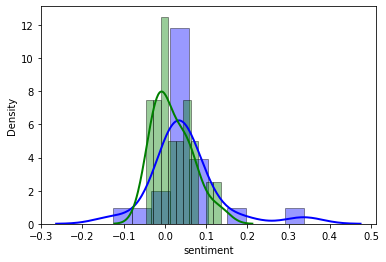

In [224]:
import seaborn as sns
import matplotlib as plt
#sns.histplot()

#Rihanna_hist= sns.histplot(data=[rLyrics,tLyrics], x="sentiment")
#Rihanna_hist.set_title("Rihanna")

sns.distplot(tLyrics["sentiment"], hist=True, kde=True, hist_kws={'edgecolor':'black'}, kde_kws={'linewidth':2}, bins=10, color='blue')
sns.distplot(rLyrics["sentiment"],hist=True, kde=True, hist_kws={'edgecolor':'black'}, kde_kws={'linewidth':2}, bins=10, color='green')
#ax.set_xticks(np.arange(-20,121,20))
#ax.set_yticks(np.arange(0.0,0.07,0.01))
#ax.spines['top'].set_visible(False)
#ax.spines['right'].set_visible(False)



In [225]:
rLyrics = lyrics_data[lyrics_data["artist"]=="rihanna"]
tLyrics = lyrics_data[lyrics_data["artist"]!="rihanna"]

rAvgSentiment = rLyrics["sentiment"].mean()
print("Rihanna has an average sentiment of",rAvgSentiment)

tAvgSentiment = tLyrics["sentiment"].mean()
print("Taylor has an average sentiment of",tAvgSentiment)

Rihanna has an average sentiment of 0.018926712690172622
Taylor has an average sentiment of 0.048231418201006154


In [226]:
# Rihanna
rLyrics = lyrics_data[lyrics_data["artist"]=="rihanna"]
rAvgSentiment = rLyrics["sentiment"].mean()
print("Rihana has an average sentiment of",rAvgSentiment)




Rihana has an average sentiment of 0.018926712690172622


In [227]:
rMaxSentiment = rLyrics["sentiment"].max()
rMaxRow = rLyrics[rLyrics["sentiment"]==rMaxSentiment]
rMaxSong = rMaxRow.iloc[0,0]
#print(f"Rihanna's happiest song is {rMaxSong} ({rMaxSentiment})")

# Rihanna
##############
rLyrics = lyrics_data[lyrics_data["artist"]=="rihanna"]
rAvgSentiment = rLyrics["sentiment"].mean()
print("Rihanna has an average sentiment of",rAvgSentiment)

rMaxSentiment = rLyrics["sentiment"].max()
rMaxRow = rLyrics[rLyrics["sentiment"]==rMaxSentiment]
rMaxSong = rMaxRow.iloc[0,0]
print(f"Rihanna's most positive song is {rMaxSong} ({rMaxSentiment})")

rMinSentiment = rLyrics["sentiment"].min()
rMinRow = rLyrics[rLyrics["sentiment"]==rMinSentiment]
rMinSong = rMinRow.iloc[0,0]
print(f"Rihanna's most negative song is {rMinSong} ({rMinSentiment})")


# Taylor
################
tLyrics = lyrics_data[lyrics_data["artist"]!="rihanna"]
tAvgSentiment = tLyrics["sentiment"].mean()
print("Taylor has an average sentiment of",tAvgSentiment)

tMaxSentiment = tLyrics["sentiment"].max()
tMaxRow = tLyrics[tLyrics["sentiment"]==tMaxSentiment]
tMaxSong = tMaxRow.iloc[0,0]
print(f"Taylor's most positive song is {rMaxSong} ({rMaxSentiment})")

tMinSentiment = tLyrics["sentiment"].min()
tMinRow = tLyrics[tLyrics["sentiment"]==tMinSentiment]
tMinSong = tMinRow.iloc[0,0]
print(f"Taylor's most negative song is {tMinSong} ({tMinSentiment})")

Rihanna has an average sentiment of 0.018926712690172622
Rihanna's most positive song is musicofthesun (0.13580246913580246)
Rihanna's most negative song is weride (-0.046012269938650305)
Taylor has an average sentiment of 0.048231418201006154
Taylor's most positive song is musicofthesun (0.13580246913580246)
Taylor's most negative song is picturetoburn (-0.12585034013605442)


## Sentiment Analysis on Twitter Descriptions

In this section, define two sets of emojis you designate as positive and negative. Make sure to have at least 10 emojis per set. You can learn about the most popular emojis on Twitter at [the emojitracker](https://emojitracker.com/). 

Associate your positive emojis with a score of +1, negative with -1. Score the average sentiment of your two artists based on the Twitter descriptions of their followers. The average sentiment can just be the total score divided by number of followers. 

In [253]:
positiveEmoji = "😍😀😁😂🤣😃😄😅😆😉😊😘😎🍄💜🦄♌❤️📚🧸🥑✨🏠"
negativeEmoji = "☹🙁😖😞😟😤😢😭😦😧😨😩🤯😬😰😱🥵🥶😳🤪😵😡😠🤬🥺🖕🎭"

In [229]:
artists = ['rihanna', 'taylorswift13']
twitterDFS = {}
for artist in artists:
    filePath = os.path.join("twitter", f'{artist}_followers_data.txt')
    twitterDFS[artist] = pd.read_csv(filePath,delimiter='\t')['description'].dropna().tolist()

twitterDFS

{'rihanna': ['Fancy seeing you here🦋',
  '22',
  'Great is the faithfulness of GOD to me🎇',
  'Lover of God||Medical Laboratory Scientist||Quality health advocate||Fashion designer.',
  'A hard working mommy of 7 w.w.J.d',
  'Hello Hell',
  'HON. DISH USAF VEITNAM VETERAN NURSE DAD ...',
  'Qualquer problema que você tiver comigo, é seu!🖤',
  "Don't be special, that's what im here for",
  'Swimming',
  'A Queen👸🏼| Denim Connoisseur| Video Editor 🎞|https://t.co/ZAAcvNRzqS',
  'YOLO',
  'LA REALITE ESY QUE SIDIBE NE JOUE PAS DE SON INTERET ET....',
  'Lol',
  '🥀.',
  'Nigerian Student nurse',
  '❤️\u200d🔥✌️💃💋❣️⚡️💃💥',
  'تعااارف ،، صداااقة ، فرررنددز ،، فااانز🔥🌹💐🤍❤️🤩😍🤣🥰👩\u200d❤️\u200d👨🌻',
  '...',
  'Music collection old coins an paper money artist photography right small rap tunes',
  '𝕯𝖔𝖓‘𝖙 𝖉𝖔 𝖎𝖙 𝖋𝖔𝖗 𝖋𝖆𝖒𝖊, 𝖉𝖔 𝖎𝖙 𝖋𝖔𝖗 𝖎𝖒𝖕𝖆𝖈𝖙” (ele/dele)',
  'Italian',
  'Straight to the point',
  "I'm tanzania musician....",
  'Currently a student at BYUI studying early childhood/Special Ed',
  'AbdoXHamm

In [230]:
import string

def calcEmojiment(text):
    if type(text) != str:
      return 0
    text = "".join(text.split())
    charList = list(text)
    score = 0
    total = 0
    for char in charList:
        if char in positiveEmoji:
            score += 1
        elif char in negativeEmoji:
            score -= 1
        if char not in string.ascii_letters+string.punctuation:
            total += 1

    if total == 0:
        return 0
    else:
        return score / total
print(calcEmojiment("Hello 😎🥑"))  

1.0


Q: What is the average sentiment of your two artists? 

A: Rihanna has an average sentiment of 0.018926712690172622
Taylor has an average sentiment of 0.048231418201006154

---

Q: Which positive emoji is the most popular for each artist? Which negative emoji? 

A: <!-- Your answer here --> 



In [231]:
twitterTable = []
for artist in artists:
    filePath = os.path.join("twitter", f'{artist}_followers_data.txt')
    tweetList = pd.read_csv(filePath,delimiter='\t')['description'].dropna().tolist()
    for tweet in tweetList:
        twitterRow = {
            "artist": artist,
            "tweet": tweet,
            "sentiment": calcSentiment(clean_text(tweet)),
            "emojiment": calcEmojiment(tweet)
        }
        twitterTable.append(twitterRow)

twitterDF = pd.DataFrame(twitterTable)

twitterDF.head()

,artist,tweet,sentiment,emojiment
0,rihanna,Fancy seeing you here🦋,0.250,0.0
1,rihanna,22,0.000,0.0
2,rihanna,Great is the faithfulness of GOD to me🎇,0.375,0.0
3,rihanna,Lover of God||Medical Laboratory Scientist||Qu...,0.250,0.0
4,rihanna,A hard working mommy of 7 w.w.J.d,0.000,0.0


In [232]:
def getTwitterDF(artist):
    filePath = os.path.join("twitter", f'{artist}_followers_data.txt')
    tdf = pd.read_csv(filePath,delimiter='\t')#['description'].dropna()
    tdf["bio"]= tdf['description'].apply(clean_text)
    tdf["sentiment"]=tdf['bio'].apply(calcSentiment)
    tdf["emojiment"]=tdf['description'].apply(calcEmojiment)
    return tdf

tTwitterDF = getTwitterDF("taylorswift13")
rTwitterDF = getTwitterDF("rihanna")

tTwitterDF.head()
rTwitterDF.head()

,screen_name,name,id,location,followers_count,friends_count,description,bio,sentiment,emojiment
0,elleen55,Ellene,1454912448876720130,NaN,0,11,Fancy seeing you here🦋,fancy seeing you here,0.250,0.0
1,Carolin49328750,Carolina Alvarado,1527744736726945792,NaN,0,4,NaN,,0.000,0.0
2,Elly01836090,Elly,1518240219010584576,NaN,0,13,22,,0.000,0.0
3,Diana60109,Diana,1527750089447460864,NaN,0,17,Great is the faithfulness of GOD to me🎇,great is the faithfulness of god to me,0.375,0.0
4,nayzledayzle,Nayzledayzle,1527735264076083200,NaN,0,77,NaN,,0.000,0.0


In [256]:
def calcEmojiment(text):
    if type(text) != str:
      return 0
    text = "".join(text.split())
    charList = list(text)
    score = 0
    total = 0
    for char in charList:
        if char in positiveEmoji:
            score += 1
        elif char in negativeEmoji:
            score -= 1
        if char not in string.ascii_letters+string.punctuation:
            total += 1

    if total == 0:
        return 0
    else:
        return score / total


def emojiTrack(artistDF, positive=True):
    emojiTracker = {}
    if positive:
        releventEmojis = positiveEmoji
    else:
        releventEmojis = negativeEmoji

    for i,row in artistDF.iterrows():
        if type(row['description']) == str:  
            for character in row['description']:  
                if character in releventEmojis:
                    if character in emojiTracker:  
                        emojiTracker[character] += 1  
                    else:  
                        emojiTracker[character] = 1
    mostEmoji = ""
    mostCount = 0
    for key,value in emojiTracker.items():
        if len(key) > 0 and value > mostCount:
            mostEmoji = key
            mostCount = value
    print(emojiTracker)
    return mostEmoji, mostCount


pTaylor, ptc = emojiTrack(tTwitterDF, positive=True)
print(f"Taylors most common positive emoji {pTaylor} ({ptc})")

nTaylor , ntc = emojiTrack(tTwitterDF, positive=False)
print(f"Taylors most common negative emoji {nTaylor} ({ntc})")

pRihanna, prc = emojiTrack(rTwitterDF, positive=True)
print(f"Rihanna most common positive emoji {pRihanna} ({prc})")

nRihanna, nrc = emojiTrack(rTwitterDF, positive=False)
print(f"Rihanna most common negative emoji {nRihanna} ({nrc})")


{'🧸': 10, '🥑': 5, '📚': 12, '❤': 95, '️': 160, '💜': 55, '🍄': 26, '🦄': 49, '♌': 51, '✨': 91}
Taylors most common positive emoji ️ (160)
{'🖕': 255}
Taylors most common negative emoji 🖕 (255)
{'❤': 192, '️': 643, '😍': 51, '🤣': 51, '😎': 51, '💜': 51, '😉': 41}
Rihanna most common positive emoji ️ (643)
{'🤯': 51}
Rihanna most common negative emoji 🤯 (51)
